[View in Colaboratory](https://colab.research.google.com/github/keicoon/AutoEncoder/blob/master/VAE_CelebA.ipynb)

### 목표
- AutoEncoder에 CelebA 데이터를 넣어 Variational한 결과물을 얻는다

### 과정
- celebA를 local에 다운받음(mnist.dataset interface를 따름)
- VAE를 training하고 variation test 결과를 얻음


In [1]:
# dependency modules
!pip install tqdm scipy requests imageio scikit-image

    100% |████████████████████████████████| 51kB 2.5MB/s 
    100% |████████████████████████████████| 3.3MB 7.9MB/s 


In [0]:
# celebA 데이터 셋을 MNIST 데이터 셋과 같이 사용할 수 있도록 함
# http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
# reference : https://github.com/carpedm20/DCGAN-tensorflow/blob/master/download.py

from glob import glob
import scipy.misc
import imageio
import skimage.transform
# util functions
def center_crop(x, crop_h, crop_w,
                resize_h=64, resize_w=64):
  if crop_w is None:
    crop_w = crop_h
  h, w = x.shape[:2]
  j = int(round((h - crop_h)/2.))
  i = int(round((w - crop_w)/2.))
  return skimage.transform.resize(x[j:j+crop_h, i:i+crop_w], [resize_h, resize_w], mode='constant')

def transform(image, input_height, input_width, 
              resize_height=64, resize_width=64, crop=True):
  cropped_image = center_crop(image, input_height, input_width, resize_height, resize_width)
  images = cropped_image.astype(np.float32)
  images = np.subtract(np.multiply(images, 1.0 / 127.5), 1.0)
  return images

def imread(path):
  image = imageio.imread(path).astype(np.float)
  return transform(image, input_height=108, input_width=108, resize_height=64, resize_width=64, crop=True).astype(np.float32)

def save_response_content(response, destination, chunk_size=32*1024):
  total_size = int(response.headers.get('content-length', 0))
  with open(destination, "wb") as f:
    for chunk in tqdm(response.iter_content(chunk_size), total=total_size,
              unit='B', unit_scale=True, desc=destination):
      if chunk: # filter out keep-alive new chunks
        f.write(chunk)
        
def get_confirm_token(response):
  for key, value in response.cookies.items():
    if key.startswith('download_warning'):
      return value
  return None

def download_file_from_google_drive(id, destination):
  URL = "https://docs.google.com/uc?export=download"
  session = requests.Session()

  response = session.get(URL, params={ 'id': id }, stream=True)
  token = get_confirm_token(response)

  if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params=params, stream=True)

  save_response_content(response, destination)
#
def maybe_download(dirpath):
    if not os.path.exists(dirpath):
      os.mkdir(dirpath)
    data_dir = 'celebA'
    if os.path.exists(os.path.join(dirpath, data_dir)):
      print('Found Celeb-A - skip')
      return os.path.join(dirpath, "celebA", "*.jpg")

    filename, drive_id  = "img_align_celeba.zip", "0B7EVK8r0v71pZjFTYXZWM3FlRnM"
    save_path = os.path.join(dirpath, filename)

    if os.path.exists(save_path):
      print('[*] {} already exists'.format(save_path))
    else:
      download_file_from_google_drive(drive_id, save_path)

    zip_dir = ''
    with zipfile.ZipFile(save_path) as zf:
      zip_dir = zf.namelist()[0]
      zf.extractall(dirpath)
    os.remove(save_path)
    os.rename(os.path.join(dirpath, zip_dir), os.path.join(dirpath, data_dir))
    
    return os.path.join(dirpath, "celebA", "*.jpg")
# reference: https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/contrib/learn/python/learn/datasets/mnist.py
class DataSet(object):
  def __init__(self, images):
    self._num_examples = images.shape[0]
    self._images = images
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
      return self._images

  @property
  def num_examples(self):
      return self._num_examples

  @property
  def epochs_completed(self):
      return self._epochs_completed
  
  def next_batch(self, batch_size, shuffle=True):
    start = self._index_in_epoch
    if self._epochs_completed == 0 and start == 0 and shuffle:
      perm0 = np.arange(self._num_examples)
      np.random.shuffle(perm0)
      self._images = self.images[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      images_rest_part = self._images[start:self._num_examples]
      # Shuffle the data
      if shuffle:
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._images = self.images[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      images_new_part = self._images[start:end]
      return np.concatenate((images_rest_part, images_new_part), axis=0)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      return self._images[start:end]

  def read_data_sets(train_dir):
    class DataSets(object):
        pass  
    data_sets = DataSets()
    
    local_file = maybe_download(train_dir)
    local_data = glob(local_file)
    
    if len(local_data) == 0:
      raise Exception("[!] No data found in '" + data_path + "'")
    
    train_images = np.asarray([imread(data) for data in local_data[:3000]])
    
    data_sets.train = DataSet(train_images) # not ready to use label data.
    
    return data_sets

In [18]:
import os
import zipfile
import requests

import numpy as np
import tensorflow as tf

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

celebA = DataSet.read_data_sets("data/")
print('celebA.train.num_examples : ', celebA.train.num_examples)

Found Celeb-A - skip
celebA.train.num_examples :  3000


In [0]:
# VAE
# reference : https://github.com/keicoon/AutoEncoder/blob/master/VAE.ipynb
n_z = 100
def VAE(X):
    # encoder
    c1 = tf.contrib.layers.conv2d(X,   64, 5, 2, activation_fn=tf.nn.relu)
    c2 = tf.contrib.layers.conv2d(c1, 128, 5, 2, activation_fn=tf.nn.relu)
    c3 = tf.contrib.layers.conv2d(c2, 256, 5, 2, activation_fn=tf.nn.relu)
    c4 = tf.contrib.layers.conv2d(c3, 512, 5, 2, activation_fn=tf.nn.relu)
    encoder = tf.reshape(c4, shape=(-1, 4 * 4 * 512))
    # variational feature
    mu = tf.layers.dense(encoder, n_z)
    log_sigma = tf.layers.dense(encoder, n_z)
    eps = tf.random_normal(tf.shape(log_sigma))
    # dimension of latent
    z = mu + tf.sqrt(tf.exp(log_sigma)) * eps
    z = tf.identity(z, name="z")
    # decoder
    decoder = tf.layers.dense(z, 4 * 4 * 512)
    decoder = tf.reshape(decoder, shape=(-1, 4, 4, 512))
    dc1 = tf.contrib.layers.conv2d_transpose(decoder, 256, 5, 2, activation_fn=tf.nn.relu)
    dc2 = tf.contrib.layers.conv2d_transpose(dc1,     128, 5, 2, activation_fn=tf.nn.relu)
    dc3 = tf.contrib.layers.conv2d_transpose(dc2,      64, 5, 2, activation_fn=tf.nn.relu)
    Y =  tf.contrib.layers.conv2d_transpose(dc3,       3, 5, 2, activation_fn=tf.nn.tanh)
    Y= tf.identity(Y, name="Y")
    # loss
    rec_loss = tf.losses.mean_squared_error(X, Y)
    kld_loss = -tf.reduce_mean(0.5 * (1 + log_sigma - tf.square(mu) - tf.exp(log_sigma)))
    loss = rec_loss + kld_loss * 0.05
    loss = tf.identity(loss, name="loss")
    
    return Y, z, loss

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

tf.reset_default_graph()

batch_size = 64
n_samples = int(celebA.train.num_examples)
total_batch = int(n_samples / batch_size)

X = tf.placeholder(tf.float32, [None, 64, 64, 3], name="X")
Y, z, loss = VAE(X)

train_op = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss)

saver = tf.train.Saver()

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [21]:
# Train

def train():
  training_epochs = 50
  
  for epoch in range(training_epochs):
    avg_loss = 0.
    
    pbar = tqdm(range(total_batch))
    
    for i in pbar:
      batch_x = celebA.train.next_batch(batch_size)
      
      _, total_loss = sess.run([train_op, loss], feed_dict={X: batch_x})
      
      avg_loss += total_loss / total_batch
      pbar.set_description("loss : %f" % avg_loss)
    
train()

loss : 0.058814: 100%|██████████| 46/46 [00:06<00:00,  6.84it/s]


In [0]:
frozen_graph_def = tf.graph_util.convert_variables_to_constants(
    sess, 
    tf.get_default_graph().as_graph_def(), 
    ["Y", "z", "loss"]
)

with tf.gfile.GFile("./tmp/" + "VAE_CelebA_frozen.pb", "wb") as f:
    f.write(frozen_graph_def.SerializeToString())

INFO:tensorflow:Froze 22 variables.
INFO:tensorflow:Converted 22 variables to const ops.


Original Images


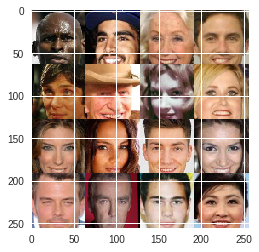

Reconstructed Images


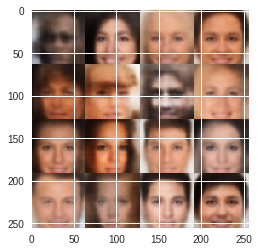

In [25]:
# Test
def test():
    n = 4
    
    canvas_orig = np.empty((64 * n, 64 * n, 3))
    canvas_recon = np.empty((64 * n, 64 * n, 3))
    for i in range(n):
        batch_x = celebA.train.next_batch(n)
        
        recon = sess.run(Y, feed_dict={X: batch_x})

        # Display original images
        for j in range(n):
            # Draw the generated digits
            batch_x[j] = np.multiply(np.add(batch_x[j], 1.0), 0.5)
            canvas_orig[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = batch_x[j]
        # Display reconstructed images
        for j in range(n):
            # Draw the generated digits
            recon[j] = np.multiply(np.add(recon[j], 1.0), 0.5)
            canvas_recon[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = recon[j]

    print("Original Images")
    plt.imshow(canvas_orig)
    plt.show()

    print("Reconstructed Images")
    plt.imshow(canvas_recon)
    plt.show()
    
test()

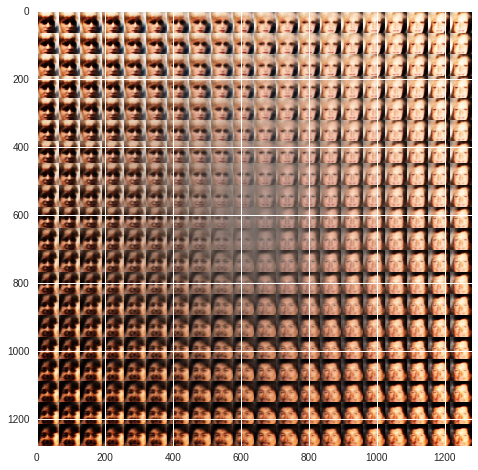

In [26]:
n = 20
x = np.linspace(-3, 3, n)
y = np.linspace(-3, 3, n)

I_latent = np.empty((64 * n, 64 * n, 3))

for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        batch_z = np.array([np.tile([xi, yi], n_z // 2)] * 1)
        recon = sess.run(Y, feed_dict={z: batch_z})
        recon[0] = np.multiply(np.add(recon[0], 1.0), 0.5)
        I_latent[(n - i - 1) * 64:(n - i) * 64, j * 64:(j + 1) * 64] = recon[0].reshape(64, 64, 3)

plt.figure(figsize=(8, 8))
plt.imshow(I_latent)